In [15]:
import torch
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
import torch.nn as nn
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10)
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [29]:
import numpy as np
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train(model, train_loader, optimizer, loss_fn, print_every=100):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
#         if iteration % print_every == 0:
#             print('Training iteration {}: loss {:.4f}'.format(iteration, loss.item()))
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
            
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
#     print('Test average loss: {:.4f}, accuracy: {:.3f}'.format(average_loss, accuracy))
    return average_loss, accuracy


def fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=None):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if scheduler:
            scheduler.step() # argument only needed for ReduceLROnPlateau
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                          train_losses[-1],
                                                                                                          train_accuracies[-1],
                                                                                                          val_losses[-1],
                                                                                                          val_accuracies[-1]))
    
    return val_accuracies

In [30]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=100, shuffle=True)


In [31]:
for tensor in train_loader:
    print(tensor[0].shape)
    break

torch.Size([100, 1, 28, 28])


Epoch 1/25: train_loss: 0.3783, train_accuracy: 88.6300, val_loss: 0.1862, val_accuracy: 93.9300
Epoch 2/25: train_loss: 0.1580, train_accuracy: 95.1383, val_loss: 0.1357, val_accuracy: 95.9100
Epoch 3/25: train_loss: 0.1163, train_accuracy: 96.4417, val_loss: 0.1138, val_accuracy: 96.6400
Epoch 4/25: train_loss: 0.0919, train_accuracy: 97.0750, val_loss: 0.1194, val_accuracy: 96.6000
Epoch 5/25: train_loss: 0.0763, train_accuracy: 97.6017, val_loss: 0.1006, val_accuracy: 96.9500
Epoch 6/25: train_loss: 0.0652, train_accuracy: 97.8900, val_loss: 0.0934, val_accuracy: 97.1100
Epoch 7/25: train_loss: 0.0560, train_accuracy: 98.1733, val_loss: 0.0971, val_accuracy: 97.1800
Epoch 8/25: train_loss: 0.0497, train_accuracy: 98.3567, val_loss: 0.0960, val_accuracy: 97.2300
Epoch 9/25: train_loss: 0.0427, train_accuracy: 98.5600, val_loss: 0.1088, val_accuracy: 97.0000
Epoch 10/25: train_loss: 0.0408, train_accuracy: 98.6417, val_loss: 0.1082, val_accuracy: 97.2100
Epoch 11/25: train_loss: 0.03

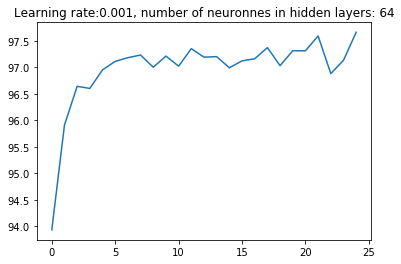

Epoch 1/25: train_loss: 0.3047, train_accuracy: 90.5100, val_loss: 0.1414, val_accuracy: 95.5700
Epoch 2/25: train_loss: 0.1317, train_accuracy: 95.9083, val_loss: 0.1354, val_accuracy: 95.8400
Epoch 3/25: train_loss: 0.0998, train_accuracy: 96.8833, val_loss: 0.1219, val_accuracy: 96.3000
Epoch 4/25: train_loss: 0.0827, train_accuracy: 97.4783, val_loss: 0.1054, val_accuracy: 96.6700
Epoch 5/25: train_loss: 0.0721, train_accuracy: 97.6783, val_loss: 0.1133, val_accuracy: 96.4700
Epoch 6/25: train_loss: 0.0622, train_accuracy: 98.0300, val_loss: 0.0919, val_accuracy: 97.4100
Epoch 7/25: train_loss: 0.0563, train_accuracy: 98.2000, val_loss: 0.0918, val_accuracy: 97.3300
Epoch 8/25: train_loss: 0.0490, train_accuracy: 98.4467, val_loss: 0.1095, val_accuracy: 97.1500
Epoch 9/25: train_loss: 0.0464, train_accuracy: 98.4900, val_loss: 0.0939, val_accuracy: 97.5500
Epoch 10/25: train_loss: 0.0422, train_accuracy: 98.6033, val_loss: 0.1153, val_accuracy: 97.1000
Epoch 11/25: train_loss: 0.03

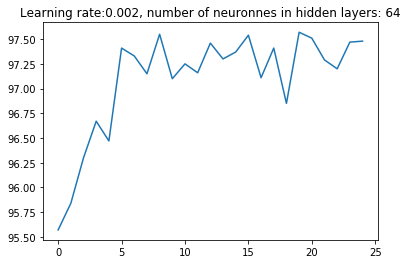

Epoch 1/25: train_loss: 0.2664, train_accuracy: 91.8250, val_loss: 0.1498, val_accuracy: 95.3500
Epoch 2/25: train_loss: 0.1403, train_accuracy: 95.6883, val_loss: 0.1326, val_accuracy: 95.7700
Epoch 3/25: train_loss: 0.1169, train_accuracy: 96.4767, val_loss: 0.1374, val_accuracy: 96.0300
Epoch 4/25: train_loss: 0.1005, train_accuracy: 96.9850, val_loss: 0.1070, val_accuracy: 96.7700
Epoch 5/25: train_loss: 0.0912, train_accuracy: 97.2650, val_loss: 0.1269, val_accuracy: 96.4700
Epoch 6/25: train_loss: 0.0830, train_accuracy: 97.5483, val_loss: 0.1355, val_accuracy: 96.3600
Epoch 7/25: train_loss: 0.0809, train_accuracy: 97.6150, val_loss: 0.1147, val_accuracy: 96.8100
Epoch 8/25: train_loss: 0.0740, train_accuracy: 97.8167, val_loss: 0.1182, val_accuracy: 96.9700
Epoch 9/25: train_loss: 0.0725, train_accuracy: 97.7633, val_loss: 0.1436, val_accuracy: 96.6400
Epoch 10/25: train_loss: 0.0689, train_accuracy: 97.9300, val_loss: 0.1223, val_accuracy: 97.1100
Epoch 11/25: train_loss: 0.06

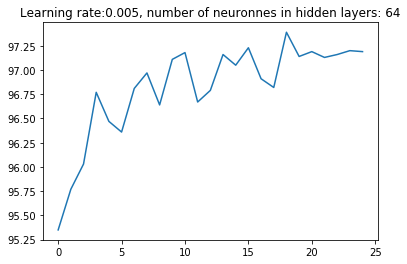

Epoch 1/25: train_loss: 0.2928, train_accuracy: 91.3533, val_loss: 0.1837, val_accuracy: 94.4500
Epoch 2/25: train_loss: 0.1800, train_accuracy: 94.9633, val_loss: 0.1779, val_accuracy: 95.3300
Epoch 3/25: train_loss: 0.1652, train_accuracy: 95.4633, val_loss: 0.1851, val_accuracy: 95.6500
Epoch 4/25: train_loss: 0.1486, train_accuracy: 96.0017, val_loss: 0.1820, val_accuracy: 95.4800
Epoch 5/25: train_loss: 0.1328, train_accuracy: 96.4300, val_loss: 0.1578, val_accuracy: 96.0000
Epoch 6/25: train_loss: 0.1286, train_accuracy: 96.5617, val_loss: 0.1831, val_accuracy: 95.8100
Epoch 7/25: train_loss: 0.1287, train_accuracy: 96.6967, val_loss: 0.1845, val_accuracy: 95.8700
Epoch 8/25: train_loss: 0.1181, train_accuracy: 96.9367, val_loss: 0.1787, val_accuracy: 95.7300
Epoch 9/25: train_loss: 0.1076, train_accuracy: 97.2417, val_loss: 0.1618, val_accuracy: 96.6000
Epoch 10/25: train_loss: 0.1148, train_accuracy: 97.1583, val_loss: 0.2351, val_accuracy: 95.1600
Epoch 11/25: train_loss: 0.10

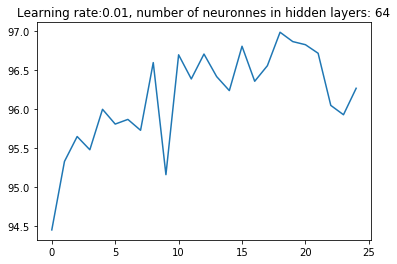

Epoch 1/25: train_loss: 2.6846, train_accuracy: 10.9250, val_loss: 2.3032, val_accuracy: 11.3500
Epoch 2/25: train_loss: 2.3099, train_accuracy: 10.5533, val_loss: 2.3066, val_accuracy: 10.3200
Epoch 3/25: train_loss: 2.3079, train_accuracy: 10.2283, val_loss: 2.3053, val_accuracy: 10.0900
Epoch 4/25: train_loss: 2.3079, train_accuracy: 10.2900, val_loss: 2.3085, val_accuracy: 9.8000
Epoch 5/25: train_loss: 2.3075, train_accuracy: 10.4383, val_loss: 2.3039, val_accuracy: 11.3500
Epoch 6/25: train_loss: 2.3083, train_accuracy: 10.2133, val_loss: 2.3060, val_accuracy: 10.1000
Epoch 7/25: train_loss: 2.3080, train_accuracy: 10.5450, val_loss: 2.3108, val_accuracy: 8.9200
Epoch 8/25: train_loss: 2.3082, train_accuracy: 10.4033, val_loss: 2.3051, val_accuracy: 10.1000
Epoch 9/25: train_loss: 2.3078, train_accuracy: 10.3650, val_loss: 2.3079, val_accuracy: 10.0900
Epoch 10/25: train_loss: 2.3084, train_accuracy: 10.2600, val_loss: 2.3069, val_accuracy: 9.8200
Epoch 11/25: train_loss: 2.3080,

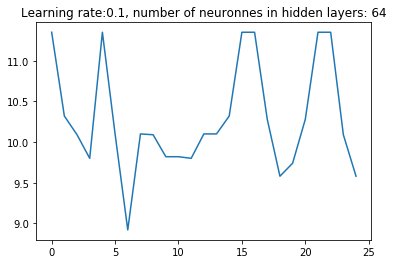

Epoch 1/25: train_loss: 115.6374, train_accuracy: 10.2833, val_loss: 36.4982, val_accuracy: 11.3500
Epoch 2/25: train_loss: 2.3290, train_accuracy: 10.1383, val_loss: 36.5161, val_accuracy: 9.8000
Epoch 3/25: train_loss: 2.3331, train_accuracy: 10.2533, val_loss: 36.5111, val_accuracy: 10.2800
Epoch 4/25: train_loss: 2.3309, train_accuracy: 10.1700, val_loss: 36.5199, val_accuracy: 10.3100
Epoch 5/25: train_loss: 2.3305, train_accuracy: 10.2933, val_loss: 36.5029, val_accuracy: 9.8200
Epoch 6/25: train_loss: 2.3333, train_accuracy: 10.2867, val_loss: 36.5374, val_accuracy: 9.8000
Epoch 7/25: train_loss: 2.3305, train_accuracy: 10.3550, val_loss: 36.5153, val_accuracy: 11.3500
Epoch 8/25: train_loss: 2.3285, train_accuracy: 10.0867, val_loss: 36.5188, val_accuracy: 10.3100
Epoch 9/25: train_loss: 2.3327, train_accuracy: 10.0950, val_loss: 36.5212, val_accuracy: 10.2800
Epoch 10/25: train_loss: 2.3321, train_accuracy: 10.1067, val_loss: 36.5175, val_accuracy: 10.2800
Epoch 11/25: train_l

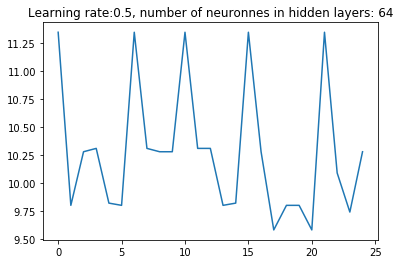

Epoch 1/25: train_loss: 1848.0470, train_accuracy: 10.1867, val_loss: 2.3219, val_accuracy: 10.3200
Epoch 2/25: train_loss: 183.6415, train_accuracy: 10.2350, val_loss: 2.3212, val_accuracy: 10.2800
Epoch 3/25: train_loss: 3.1719, train_accuracy: 10.2933, val_loss: 2.3716, val_accuracy: 11.3500
Epoch 4/25: train_loss: 2.3534, train_accuracy: 10.0717, val_loss: 2.3518, val_accuracy: 9.8000
Epoch 5/25: train_loss: 2.3559, train_accuracy: 10.0700, val_loss: 2.3409, val_accuracy: 9.7400
Epoch 6/25: train_loss: 2.3553, train_accuracy: 10.0717, val_loss: 2.3561, val_accuracy: 11.3500
Epoch 7/25: train_loss: 2.3560, train_accuracy: 10.1667, val_loss: 2.3433, val_accuracy: 9.8000
Epoch 8/25: train_loss: 2.3523, train_accuracy: 10.3550, val_loss: 2.3764, val_accuracy: 10.1000
Epoch 9/25: train_loss: 2.3578, train_accuracy: 10.2133, val_loss: 2.3758, val_accuracy: 9.8200
Epoch 10/25: train_loss: 2.3562, train_accuracy: 10.1400, val_loss: 2.3273, val_accuracy: 9.5800
Epoch 11/25: train_loss: 2.35

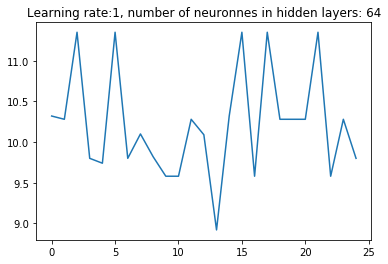

Epoch 1/25: train_loss: 0.2965, train_accuracy: 90.9733, val_loss: 0.1338, val_accuracy: 96.1000
Epoch 2/25: train_loss: 0.1139, train_accuracy: 96.4917, val_loss: 0.0959, val_accuracy: 97.0600
Epoch 3/25: train_loss: 0.0783, train_accuracy: 97.5317, val_loss: 0.0976, val_accuracy: 97.0200
Epoch 4/25: train_loss: 0.0619, train_accuracy: 97.9700, val_loss: 0.0776, val_accuracy: 97.6100
Epoch 5/25: train_loss: 0.0515, train_accuracy: 98.3517, val_loss: 0.0764, val_accuracy: 97.6900
Epoch 6/25: train_loss: 0.0423, train_accuracy: 98.5950, val_loss: 0.0807, val_accuracy: 97.6400
Epoch 7/25: train_loss: 0.0344, train_accuracy: 98.8650, val_loss: 0.0951, val_accuracy: 97.2700
Epoch 8/25: train_loss: 0.0329, train_accuracy: 98.9117, val_loss: 0.0860, val_accuracy: 97.5200
Epoch 9/25: train_loss: 0.0287, train_accuracy: 98.9933, val_loss: 0.0850, val_accuracy: 97.7500
Epoch 10/25: train_loss: 0.0222, train_accuracy: 99.2650, val_loss: 0.1089, val_accuracy: 97.5600
Epoch 11/25: train_loss: 0.02

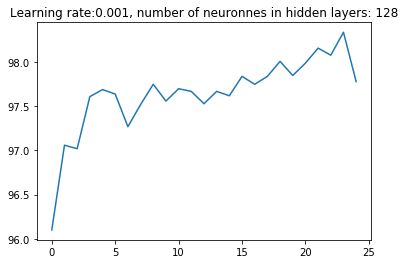

Epoch 1/25: train_loss: 0.2594, train_accuracy: 92.0667, val_loss: 0.1255, val_accuracy: 96.3600
Epoch 2/25: train_loss: 0.1104, train_accuracy: 96.6100, val_loss: 0.0973, val_accuracy: 97.1900
Epoch 3/25: train_loss: 0.0828, train_accuracy: 97.3783, val_loss: 0.1041, val_accuracy: 96.8800
Epoch 4/25: train_loss: 0.0652, train_accuracy: 97.9083, val_loss: 0.0819, val_accuracy: 97.4600
Epoch 5/25: train_loss: 0.0555, train_accuracy: 98.2517, val_loss: 0.0888, val_accuracy: 97.3700
Epoch 6/25: train_loss: 0.0474, train_accuracy: 98.4583, val_loss: 0.1030, val_accuracy: 97.0400
Epoch 7/25: train_loss: 0.0420, train_accuracy: 98.7000, val_loss: 0.0860, val_accuracy: 97.5500
Epoch 8/25: train_loss: 0.0376, train_accuracy: 98.8017, val_loss: 0.0955, val_accuracy: 97.4800
Epoch 9/25: train_loss: 0.0362, train_accuracy: 98.8500, val_loss: 0.0753, val_accuracy: 97.8300
Epoch 10/25: train_loss: 0.0305, train_accuracy: 99.0167, val_loss: 0.0932, val_accuracy: 97.6900
Epoch 11/25: train_loss: 0.03

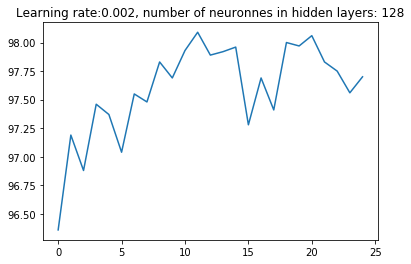

Epoch 1/25: train_loss: 0.2527, train_accuracy: 92.1400, val_loss: 0.1353, val_accuracy: 96.1000
Epoch 2/25: train_loss: 0.1347, train_accuracy: 96.0517, val_loss: 0.1391, val_accuracy: 96.0700
Epoch 3/25: train_loss: 0.1109, train_accuracy: 96.7900, val_loss: 0.1222, val_accuracy: 96.5200
Epoch 4/25: train_loss: 0.0931, train_accuracy: 97.3267, val_loss: 0.1152, val_accuracy: 96.8900
Epoch 5/25: train_loss: 0.0881, train_accuracy: 97.4533, val_loss: 0.1193, val_accuracy: 96.8100
Epoch 6/25: train_loss: 0.0801, train_accuracy: 97.7100, val_loss: 0.1105, val_accuracy: 97.2600
Epoch 7/25: train_loss: 0.0726, train_accuracy: 97.8883, val_loss: 0.1169, val_accuracy: 97.0600
Epoch 8/25: train_loss: 0.0738, train_accuracy: 97.8700, val_loss: 0.1541, val_accuracy: 96.3300
Epoch 9/25: train_loss: 0.0686, train_accuracy: 98.0967, val_loss: 0.1163, val_accuracy: 97.1900
Epoch 10/25: train_loss: 0.0596, train_accuracy: 98.3300, val_loss: 0.1270, val_accuracy: 97.3900
Epoch 11/25: train_loss: 0.06

KeyboardInterrupt: 

In [37]:
nb_epochs = 25
i = 0
for hidden_layers in [64,128,256,512]:
    for learning_rate in [0.001,0.002,0.005,0.01,0.1,0.5,1]:
        model_mlp = MLPModel(28*28, hidden_layers)
        model_mlp = model_mlp.to(device)
        optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()
        accuracies = fit(train_loader, val_loader, model_mlp, optimizer, loss_fn, nb_epochs)
        plt.title('Learning rate:' + str(learning_rate) + ', number of neurons in hidden layers: ' + str(hidden_layers))
        plt.plot(accuracies)
        plt.savefig('mlp_plot/' + str(i) + '.png')
        plt.show() 
        i = i + 1
        

In [11]:
model_mlp = MLPModel(28*28, 128)
model_mlp = model_mlp.to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

In [12]:
curves_mlp = fit(train_loader, val_loader, model_mlp, optimizer, loss_fn, n_epochs)

Epoch 1/25: train_loss: 0.3037, train_accuracy: 90.9533, val_loss: 0.1428, val_accuracy: 95.4300
Epoch 2/25: train_loss: 0.1149, train_accuracy: 96.3850, val_loss: 0.1028, val_accuracy: 96.6800
Epoch 3/25: train_loss: 0.0825, train_accuracy: 97.3967, val_loss: 0.0934, val_accuracy: 97.1700
Epoch 4/25: train_loss: 0.0636, train_accuracy: 97.9750, val_loss: 0.0888, val_accuracy: 97.1700
Epoch 5/25: train_loss: 0.0510, train_accuracy: 98.4000, val_loss: 0.0964, val_accuracy: 97.2700
Epoch 6/25: train_loss: 0.0413, train_accuracy: 98.6833, val_loss: 0.0802, val_accuracy: 97.7600
Epoch 7/25: train_loss: 0.0349, train_accuracy: 98.8633, val_loss: 0.0843, val_accuracy: 97.6200
Epoch 8/25: train_loss: 0.0311, train_accuracy: 98.9400, val_loss: 0.1028, val_accuracy: 97.0400
Epoch 9/25: train_loss: 0.0293, train_accuracy: 99.0667, val_loss: 0.0784, val_accuracy: 97.9200
Epoch 10/25: train_loss: 0.0231, train_accuracy: 99.2167, val_loss: 0.0965, val_accuracy: 97.6800
Epoch 11/25: train_loss: 0.02